# Numerical computation of electric fields
<i><small>Contact: jeroen.mulkers@ugent.be</small></i>

In this little demo, we will compute the electric field of rectangular charged plates numerically. The main purpose of this demo, is to show that a scripting language like Python is an ideal tool to solve physical problems when it is too hard (or when one is too lazy) to solve it analytically.

This thing which is running in your browser right now, is called a "Jupyter notebook". Such notebooks can be used to combine text, code snippets, formulas, output figures, ... in a single well structered file.  A Python engine is running in the background to run the code snippets in the code cells. To execute a code snippet, select the code cell, and press shift+enter. Try it out on the code cell below.

In [96]:
import numpy as np
import matplotlib.pyplot as plt


eps0 = 42 # the electric constant

print("The answer =",eps0)

The answer = 42


By executing the above cell, you imported two libraries which are used quite often by scientists. The numpy library is a very useful library to work with vectors and tensors. The matplotlib library has useful plot functionalities to visualize (numpy) data. You also defined a variable for the electric constant but the value you used is totaly wrong. Please correct this before moving on, it will be used throughout this demo.

## Electric field of a rectangular plate

The electric field at a certain measure point is given by the following integral 

$$ \vec{E} = \frac{1}{4 \pi \epsilon_0} \int  \frac{\rho(\vec{r})\vec{r}}{r^3} \ \text{d}V $$

with $\rho(\vec{r})$ the charge density at a point $\vec{r}$ with respect to the point of measurement. For a charged rectangular plate lying in the $xy$-plane with its center in the origin and a uniform surface charge density $\sigma$, this 'reduces' to the following two-dimensional integral

$$ \vec{E}(x,y,z) = \frac{\sigma}{4 \pi \epsilon_0} \int^{L_x/2}_{-L_x/2}\int^{L_y/2}_{-L_y/2} 
\frac{ (x-x')\hat{e}_x + (y-y')\hat{e}_y + z \hat{e}_z}{\left( (x-x')^2 + (y-y')^2 + z^2\right)^{3/2}} \ \text{d}x'\text{d}y $$

with $L_x$ and $L_y$ the side lengths in the $x$ and $y$ direction. I don't really like to solve integrals like this one, and I guess you either. So, let's use python to solve this integral numerically. We will do this as follows:

1. Create a partition of the rectangular plate. For simplicity, we will use a regular grid of $N_x \times N_y$ rectangular cells. The dimensions of each cell are given by $\Delta x=L_x/N_x$ and $\Delta y=L_y/N_y$.

2. Compute the charge of one cell. This equals the charge density multiplied by the cell area $\Delta x \Delta y$.

3. Aproximate the integral over the plate by a finite sum over the cells.

Below you can find an implementation of this approach. The `constructPlateEfield` is a function which returns a function for the electric field of a rectangular plate with the specified properties. Read through the implementation and try to understand roughly how it works.

In [20]:
def constructPlateEfield(chargeDensity,Lx,Ly,Nx=100,Ny=100):
    
    # calculate the cell dimensions
    dx, dy = Lx/Nx, Ly/Ny
    
    # construct rectangular grid of Nx by Ny cells
    # xCell and yCell are matrices which contain the  position (of the center) of each cell 
    xCell, yCell = np.meshgrid(  np.linspace( -Lx/2+dx/2 , Lx/2-dx/2 , Nx),
                                 np.linspace( -Ly/2+dy/2 , Ly/2-dy/2 , Ny)  )
    
    # calculate the prefactor (which is the same for each cell)
    cellArea   = dx*dy
    cellCharge = chargeDensity*cellArea
    preFactor  = cellCharge/(4*np.pi*eps0) 

    
    # define the function which can be evaluated at any point in space
    # to get the electric field at that point
    def Efield(x,y,z):     
        
        # compute the denominator of the integrand for each cell  ( 1/r^3 )
        Rinv3 = np.power((x-xCell)**2+(y-yCell)**2+z**2,-3/2)
        
        # calculate electric field contributions from each cell of the rectangle
        dEx = preFactor * (x-xCell) * Rinv3
        dEy = preFactor * (y-yCell) * Rinv3
        dEz = preFactor *  z        * Rinv3 
        
        # and sum them together
        return np.sum(dEx), np.sum(dEy), np.sum(dEz)
    
    
    # return the electric field function 
    # (and make sure it accepts numpy array inputs by 'vectorizing' the function)
    return np.vectorize(Efield)


# Tip: when you 'uncomment' one of the lines below, you can read the manual of the numpy command

# help(np.linspace)
# help(np.meshgrid)
# help(np.power)

## Example 1: A single rectangular plate

Let's use the above defined function to calculate the electric field at arbitrary positions in the vicinity of a square plate with side length 3 and charge density 1. 

In [72]:
Efield = constructPlateEfield(chargeDensity=1., Lx=3, Ly=3, Nx=100, Ny=100)

# in a single point
Ex,Ey,Ez = Efield(x=1.0, y=-0.4, z=3.0)
print("Efield at a single point")
print('  Ex =', Ex)
print('  Ey =', Ey)
print('  Ez =', Ez)

# for multiple z values
Ex,Ey,Ez = Efield(x=1.0, y=-0.4, z=[3.0, -1.1, 2.1])
print("\nEfield at a multiple points")
print('  Ex =', Ex)
print('  Ey =', Ey)
print('  Ez =', Ez)

Efield at a single point
  Ex = 0.00037308082197129075
  Ey = -0.0001485780362479208
  Ez = 0.0013576136452972266

Efield at a multiple points
  Ex = [0.00037308 0.00191217 0.0007573 ]
  Ey = [-0.00014858 -0.00069514 -0.00029776]
  Ez = [ 0.00135761 -0.00432278  0.00221012]


Well, that's not saying much. Let's have a look at the profile of the electric field of a square plate along the z-axis and let's compare it to the electric field caused by a point charge:

$$ \vec{E} = \frac{Q}{4\pi\epsilon_0} \frac{\vec{r}}{r^3} $$

with a charge $Q$ which equals the total charge of the square plate.

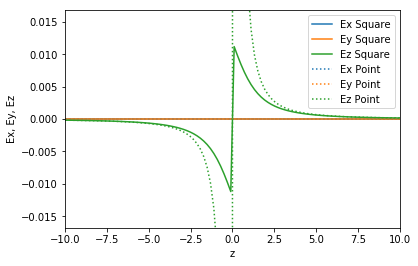

In [89]:
# the positions at which we will calculate the electric field
# (100 equaly-spaced points on the z axis between z=-10 and z=10)
x = 0.0
y = 0.0
zz = np.linspace(-10,10,100) 

# Efield SQUARE PLATE (numerically)
chargeDensity, (Lx, Ly) = 1.0, (3.0, 3.0)
Efield = constructPlateEfield(chargeDensity, Lx, Ly, Nx=100, Ny=100)
Ex_plate, Ey_plate, Ez_plate = Efield(x,y,zz)

# Efield POINT CHARGE (analytically)
totalCharge = chargeDensity*Lx*Ly # equals the total charge of the plate
Rinv3 = np.power(x**2+y**2+zz**2,-3/2) # 1/r^3
Ex_point = (totalCharge/(4*np.pi*eps0)) *  x * Rinv3
Ey_point = (totalCharge/(4*np.pi*eps0)) *  y * Rinv3
Ez_point = (totalCharge/(4*np.pi*eps0)) * zz * Rinv3

# plot the electric fields
plt.plot(zz,Ex_plate,color='C0',linestyle='-',label='Ex Square')
plt.plot(zz,Ey_plate,color='C1',linestyle='-',label='Ey Square')
plt.plot(zz,Ez_plate,color='C2',linestyle='-',label='Ez Square')
plt.plot(zz,Ex_point,color='C0',linestyle=':',label='Ex Point')
plt.plot(zz,Ey_point,color='C1',linestyle=':',label='Ey Point')
plt.plot(zz,Ez_point,color='C2',linestyle=':',label='Ez Point')
plt.xlabel("z")
plt.ylabel("Ex, Ey, Ez")
plt.xlim([zz[0],zz[-1]])
plt.ylim([1.5*np.min(Ez_plate),1.5*np.max(Ez_plate)])
plt.legend()
plt.show()

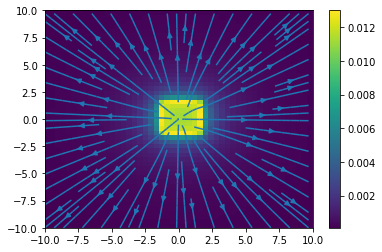

In [56]:
Efield = constructPlateEfield(chargeDensity = 1., Lx=3, Ly=3, Nx=100, Ny=100)

xx,yy = np.meshgrid( np.linspace(-10,10,50),
                     np.linspace(-10,10,50))
z = 0.10

Ex,Ey,Ez = Efield(xx,yy,z)
Emag = np.sqrt(Ex**2+Ey**2+Ez**2)

plt.pcolor(xx,yy,Emag)
plt.colorbar()
plt.streamplot(xx,yy,Ex,Ey)

## Example 2: Two parallel rectangles

In [8]:
def constructEfieldParallel(chargeDensity,distance,Lx,Ly,Nx=100,Ny=100):
    
    Efield1 = constructRectangleEfield( chargeDensity, Lx, Ly, Nx, Ny)
    Efield2 = constructRectangleEfield(-chargeDensity, Lx, Ly, Nx, Ny) # use opposite charge
    
    def Efield(x,y,z):
        Ex1,Ey1,Ez1 = Efield1(x,y,z+distance/2)
        Ex2,Ey2,Ez2 = Efield2(x,y,z-distance/2)
        return Ex1+Ex2, Ey1+Ey2, Ez1+Ez2
    
    return Efield

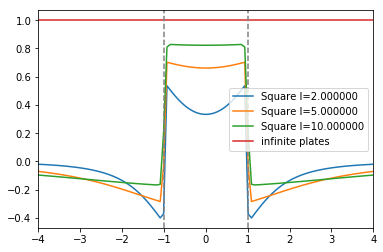

In [9]:
chargeDensity = 1.
distance = 2.

x = 0
y = 0
zz = np.linspace(-2*distance,2*distance,100)

for sideLength in [2,5,10]:
    
    Efield = constructEfieldParallel(chargeDensity,distance,Lx=sideLength,Ly=sideLength)
    
    Ex,Ey,Ez = Efield(x=0,y=0,z=zz)
    plt.plot(zz,Ez,label='Square l=%f'%sideLength)

Ez_point = chargeDensity*np.ones(zz.shape)/eps0
plt.plot(zz,Ez_point,label='infinite plates')

plt.axvline(-distance/2,ls='--',c='gray')
plt.axvline( distance/2,ls='--',c='gray')
plt.xlim([zz[0],zz[-1]])
plt.legend()
plt.show()

In [63]:
def constructEfieldNeighbours(c1,c2,distance,Lx,Ly,Nx=100,Ny=100):
    
    Efield1 = constructRectangleEfield( c1, Lx, Ly, Nx, Ny)
    Efield2 = constructRectangleEfield( c2, Lx, Ly, Nx, Ny) # use opposite charge
    
    def Efield(x,y,z):
        Ex1,Ey1,Ez1 = Efield1(x-distance/2,y,z)
        Ex2,Ey2,Ez2 = Efield2(x+distance/2,y,z)
        return Ex1+Ex2, Ey1+Ey2, Ez1+Ez2
    
    return Efield